In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
import pathlib
import cv2

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
training = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2746 files belonging to 14 classes.
Using 2197 files for training.


In [4]:
validation = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2746 files belonging to 14 classes.
Using 549 files for validation.


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

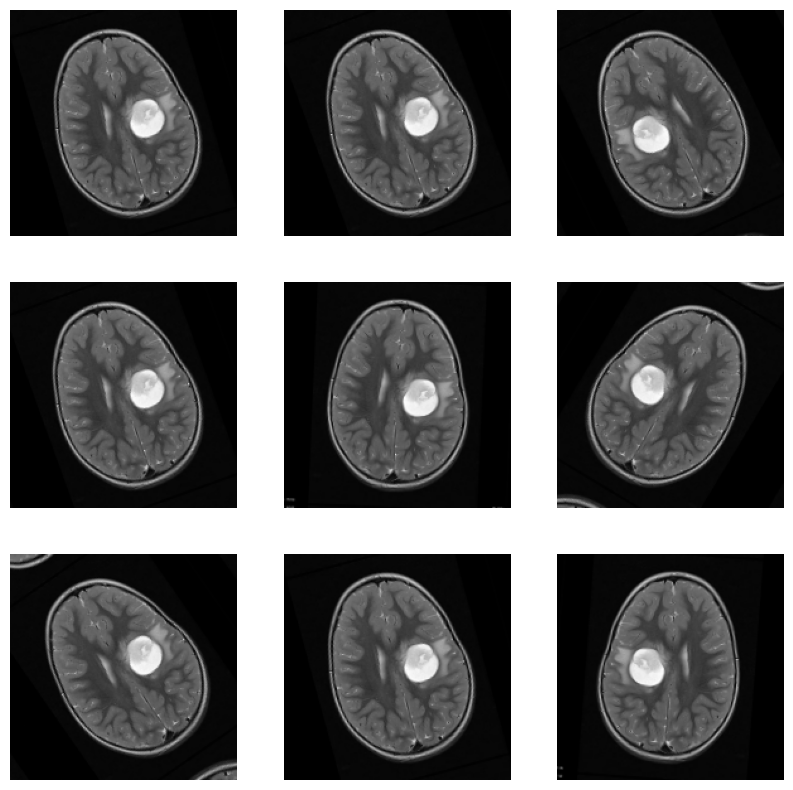

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in training.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
classes = training.class_names
print(classes)

['Astrocytoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']


In [8]:
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
training = training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normlayer = layers.Rescaling(1./255)

In [15]:
normdata = training.map(lambda x, y: (normlayer(x), y))
image_batch, labels_batch = next(iter(normdata))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9999388


In [16]:
numclass = len(classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(1024, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),    
  layers.Flatten(),
  layers.Dense(2048, activation='relu'),
  layers.Dense(numclass)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [19]:
epochs=28
history = model.fit(
  training,
  validation_data=validation,
  epochs=epochs)

Epoch 1/28
69/69 [==============================] - 86s 1s/step - loss: 2.4173 - accuracy: 0.2053 - val_loss: 2.2811 - val_accuracy: 0.2332
Epoch 2/28
69/69 [==============================] - 71s 1s/step - loss: 2.2575 - accuracy: 0.2526 - val_loss: 2.0752 - val_accuracy: 0.2896
Epoch 3/28
69/69 [==============================] - 69s 1s/step - loss: 1.8434 - accuracy: 0.3732 - val_loss: 1.5956 - val_accuracy: 0.4936
Epoch 4/28
69/69 [==============================] - 69s 999ms/step - loss: 1.3847 - accuracy: 0.5298 - val_loss: 1.2592 - val_accuracy: 0.5993
Epoch 5/28
69/69 [==============================] - 70s 1s/step - loss: 1.0550 - accuracy: 0.6359 - val_loss: 0.9185 - val_accuracy: 0.6940
Epoch 6/28
69/69 [==============================] - 69s 1s/step - loss: 0.7905 - accuracy: 0.7451 - val_loss: 0.9236 - val_accuracy: 0.7049
Epoch 7/28
69/69 [==============================] - 69s 1s/step - loss: 0.5835 - accuracy: 0.8084 - val_loss: 0.6278 - val_accuracy: 0.7996
Epoch 8/28
69/69 

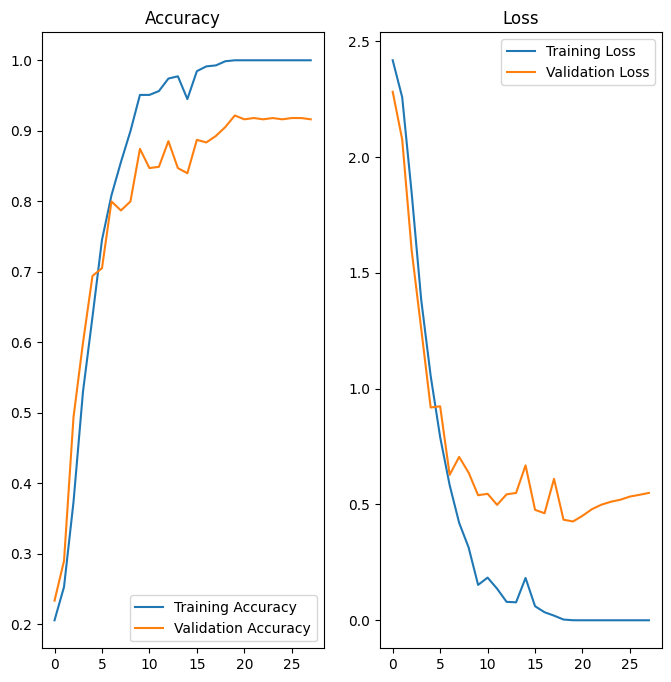

In [20]:
tacc = history.history['accuracy']
vacc = history.history['val_accuracy']

tloss = history.history['loss']
vloss = history.history['val_loss']

eprange = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(eprange, tacc, label='Training Accuracy')
plt.plot(eprange, vacc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(eprange, tloss, label='Training Loss')
plt.plot(eprange, vloss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [21]:
def prediction(datpath, model):
    img_height, img_width = 180, 180
    im = tf.keras.utils.load_img(datpath, target_size=(img_height, img_width))
    imarray = tf.keras.utils.img_to_array(im)
    imarray = tf.expand_dims(imarray, 0) 
    predict = model.predict(imarray)
    classindex = np.argmax(predict[0])
    return classindex

In [22]:
model.save('my_model.keras')
loaded_model = tf.keras.models.load_model('model.h5')

In [23]:
dat = 'C:/Users/pragn/Downloads/dataset_T2MRI/Astrocytoma/eff23c911531744a03a900b8a45c1061e06947b4a9c36994bcfde390ed5d138d_big_gallery.jpeg'
mri = cv2.imread(dat)
classindex = prediction(dat, model)

1/1 [==============================] - 1s 662ms/step


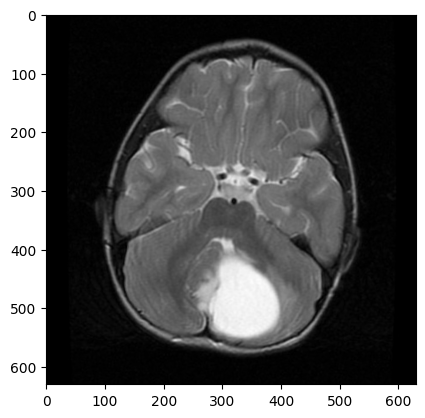

In [24]:
plt.imshow(mri)

In [25]:
seg = mri.reshape(-1, 3)
seg = np.float32(seg)

In [26]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
_,labels,centers = cv2.kmeans(seg, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
labels = labels.reshape((mri.shape[:-1]))
redu = np.uint8(centers)[labels]

In [27]:
for i, c in enumerate(centers):
    mask = cv2.inRange(labels, i, i)
    mask = np.dstack([mask]*3) 
    tumor = cv2.bitwise_and(mri, mask)

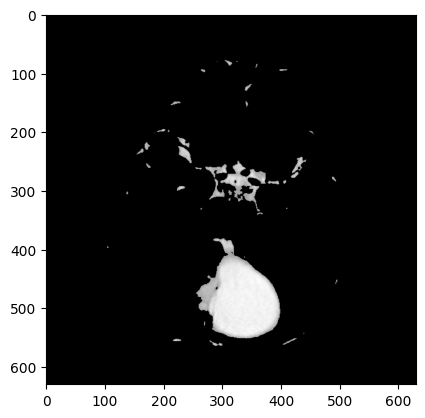

In [28]:
plt.imshow(tumor)

In [29]:
tum = tumor
grey = cv2.cvtColor(tum, cv2.COLOR_BGR2GRAY)
thresh = cv2.convertScaleAbs(grey)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
anomaly = max(contours, key=cv2.contourArea)

In [30]:
cv2.drawContours(tum, [anomaly], -1, (191, 54, 12), 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [31]:
cv2.fillPoly(tum, pts=[anomaly], color=(255, 0, 0))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [32]:
from PIL import Image
import Image

background = Image.fromarray(np.uint8(tum)).convert("RGBA")
overlay = Image.fromarray(np.uint8(mri)).convert("RGBA")

overlay.putalpha(128)
background.alpha_composite(overlay)

result = np.array(background)

NEUROSEG SUMMARY
___________________________________________
INTRACRANIAL TUMOR TYPE: Astrocytoma
TUMOR IDENTIFICATION VALIDATION ACCURACY: 92.16758012771606 %
TUMOR IDENTIFICATION TRAINING ACCURACY: 100.0 %


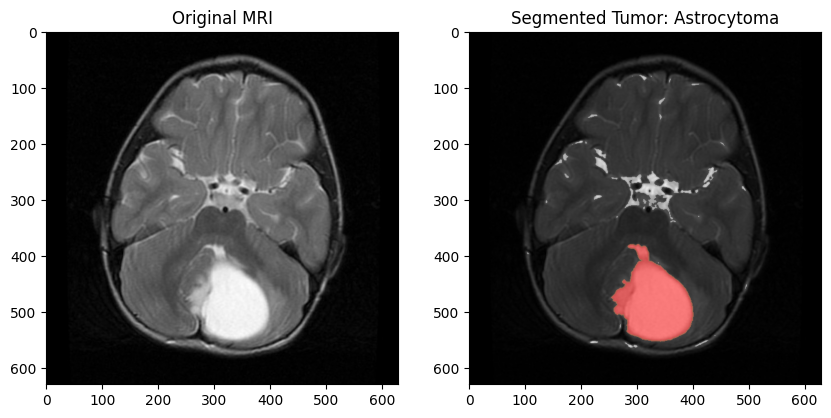

In [33]:
types = ['Astrocytoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']
print("NEUROSEG SUMMARY")
print("___________________________________________")
print("INTRACRANIAL TUMOR TYPE: "+types[classindex])
systemvacc = max(vacc)
systemtacc = max(tacc)
print("TUMOR IDENTIFICATION VALIDATION ACCURACY: "+str(100*systemvacc)+' %')
print("TUMOR IDENTIFICATION TRAINING ACCURACY: "+str(100*systemtacc)+' %')

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(mri)
plt.title('Original MRI')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title('Segmented Tumor: '+str(types[classindex]))
plt.show()